# Sentiment Analysis for Twitter

Importing various libraries that will be used for data analysis, natural language processing, and machine learning tasks

In [1]:
import warnings

# ignore all warning messages
warnings.filterwarnings('ignore')

# other modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
import nltk
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report,confusion_matrix
from sklearn.linear_model import LogisticRegression
from keras_preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Embedding, Flatten, Dense, Dropout, SpatialDropout1D, LSTM

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\2533a\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Using the Pandas library to read a CSV file and create a DataFrame object to store the data 

In [2]:
df = pd.read_csv('Twitter_Data.csv')
df.head(10)

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0
5,kiya tho refresh maarkefir comment karo,0.0
6,surat women perform yagna seeks divine grace f...,0.0
7,this comes from cabinet which has scholars lik...,0.0
8,with upcoming election india saga going import...,1.0
9,gandhi was gay does modi,1.0


## Data cleaning

Summary of the Data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


Extracting unique values from the 'category' column 

In [4]:
df.category.unique()

array([-1.,  0.,  1., nan])

Generating descriptive statistics of the data

In [5]:
df.describe()

,category
count,162973.000000
mean,0.225436
std,0.781279
min,-1.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


Counting the number of missing (null) values in each column

In [6]:
df.isna().sum()

clean_text    4
category      7
dtype: int64

In [8]:
# List of all the column names 
df.columns

Index(['clean_text', 'category'], dtype='object')

In [10]:
# Filter data to only show rows where the 'category' column has missing (null) values
df[df['category'].isna()]

,clean_text,category
130448,the foundation stone northeast gas grid inaugu...,NaN
155642,dear terrorists you can run but you cant hide ...,NaN
155698,offense the best defence with mission shakti m...,NaN
155770,have always heard politicians backing out thei...,NaN
158693,modi government plans felicitate the faceless ...,NaN
159442,chidambaram gives praises modinomics,NaN
160559,the reason why modi contested from seats 2014 ...,NaN


In [12]:
# Filter the 'clean_text' column has missing (null) values.
df[df['clean_text'].isna()]

,clean_text,category
148,NaN,0.0
158694,NaN,-1.0
159443,NaN,0.0
160560,NaN,1.0


In [14]:
# Drop missing (null) data
clean_df=df.drop(df[df['clean_text'].isna()].index, inplace=True)
cat_df=df.drop(df[df['category'].isna()].index, inplace=True)

## Preprocess function:

Takes a list of text data as input and returns a list of preprocessed text data. 
Performs several text preprocessing steps to clean and normalize the input text data for use in natural language processing tasks.
The text preprocessing steps performed by this function include:

- Converting all text to lowercase.
- Replacing URLs with the string "URL".
- Replacing emojis with a string containing the word "EMOJI" and the corresponding emoji code.
- Replacing mentions of user handles (e.g. "@username") with the string "USER".
- Removing all non-alphanumeric characters (excluding spaces).
- Replacing any sequences of three or more consecutive characters with just two copies of the same character (e.g. "looooove" becomes "loove").
- Lemmatizing each word in the text data using the WordNet lemmatizer.

In [15]:
def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

## Message Text Process Function:

This function use for preparing individual text samples for natural language processing tasks (sentiment analysis). A common technique for removing noise and irrelevant information from text data before processing it with machine learning models. The text preprocessing steps performed by this function include:

- Removing all punctuation characters
- Splitting the resulting text into a list of individual words
- Removing all stop words (common words that are unlikely to be useful for NLP tasks)

In [16]:
def message_text_process(mess):
    no_punctuation = [char for char in mess if char not in string.punctuation]
    no_punctuation = ''.join(no_punctuation)
    return [word for word in no_punctuation.split() if word.lower() 
            not in stopwords.words('english')]


# Positive tweets

- Below code generates a word cloud visualization of a collection of positive tweets from the dataset.
- Code also creates a new plot figure with a black background and displays the word cloud image.
- The last line deletes the text string to free up memory.

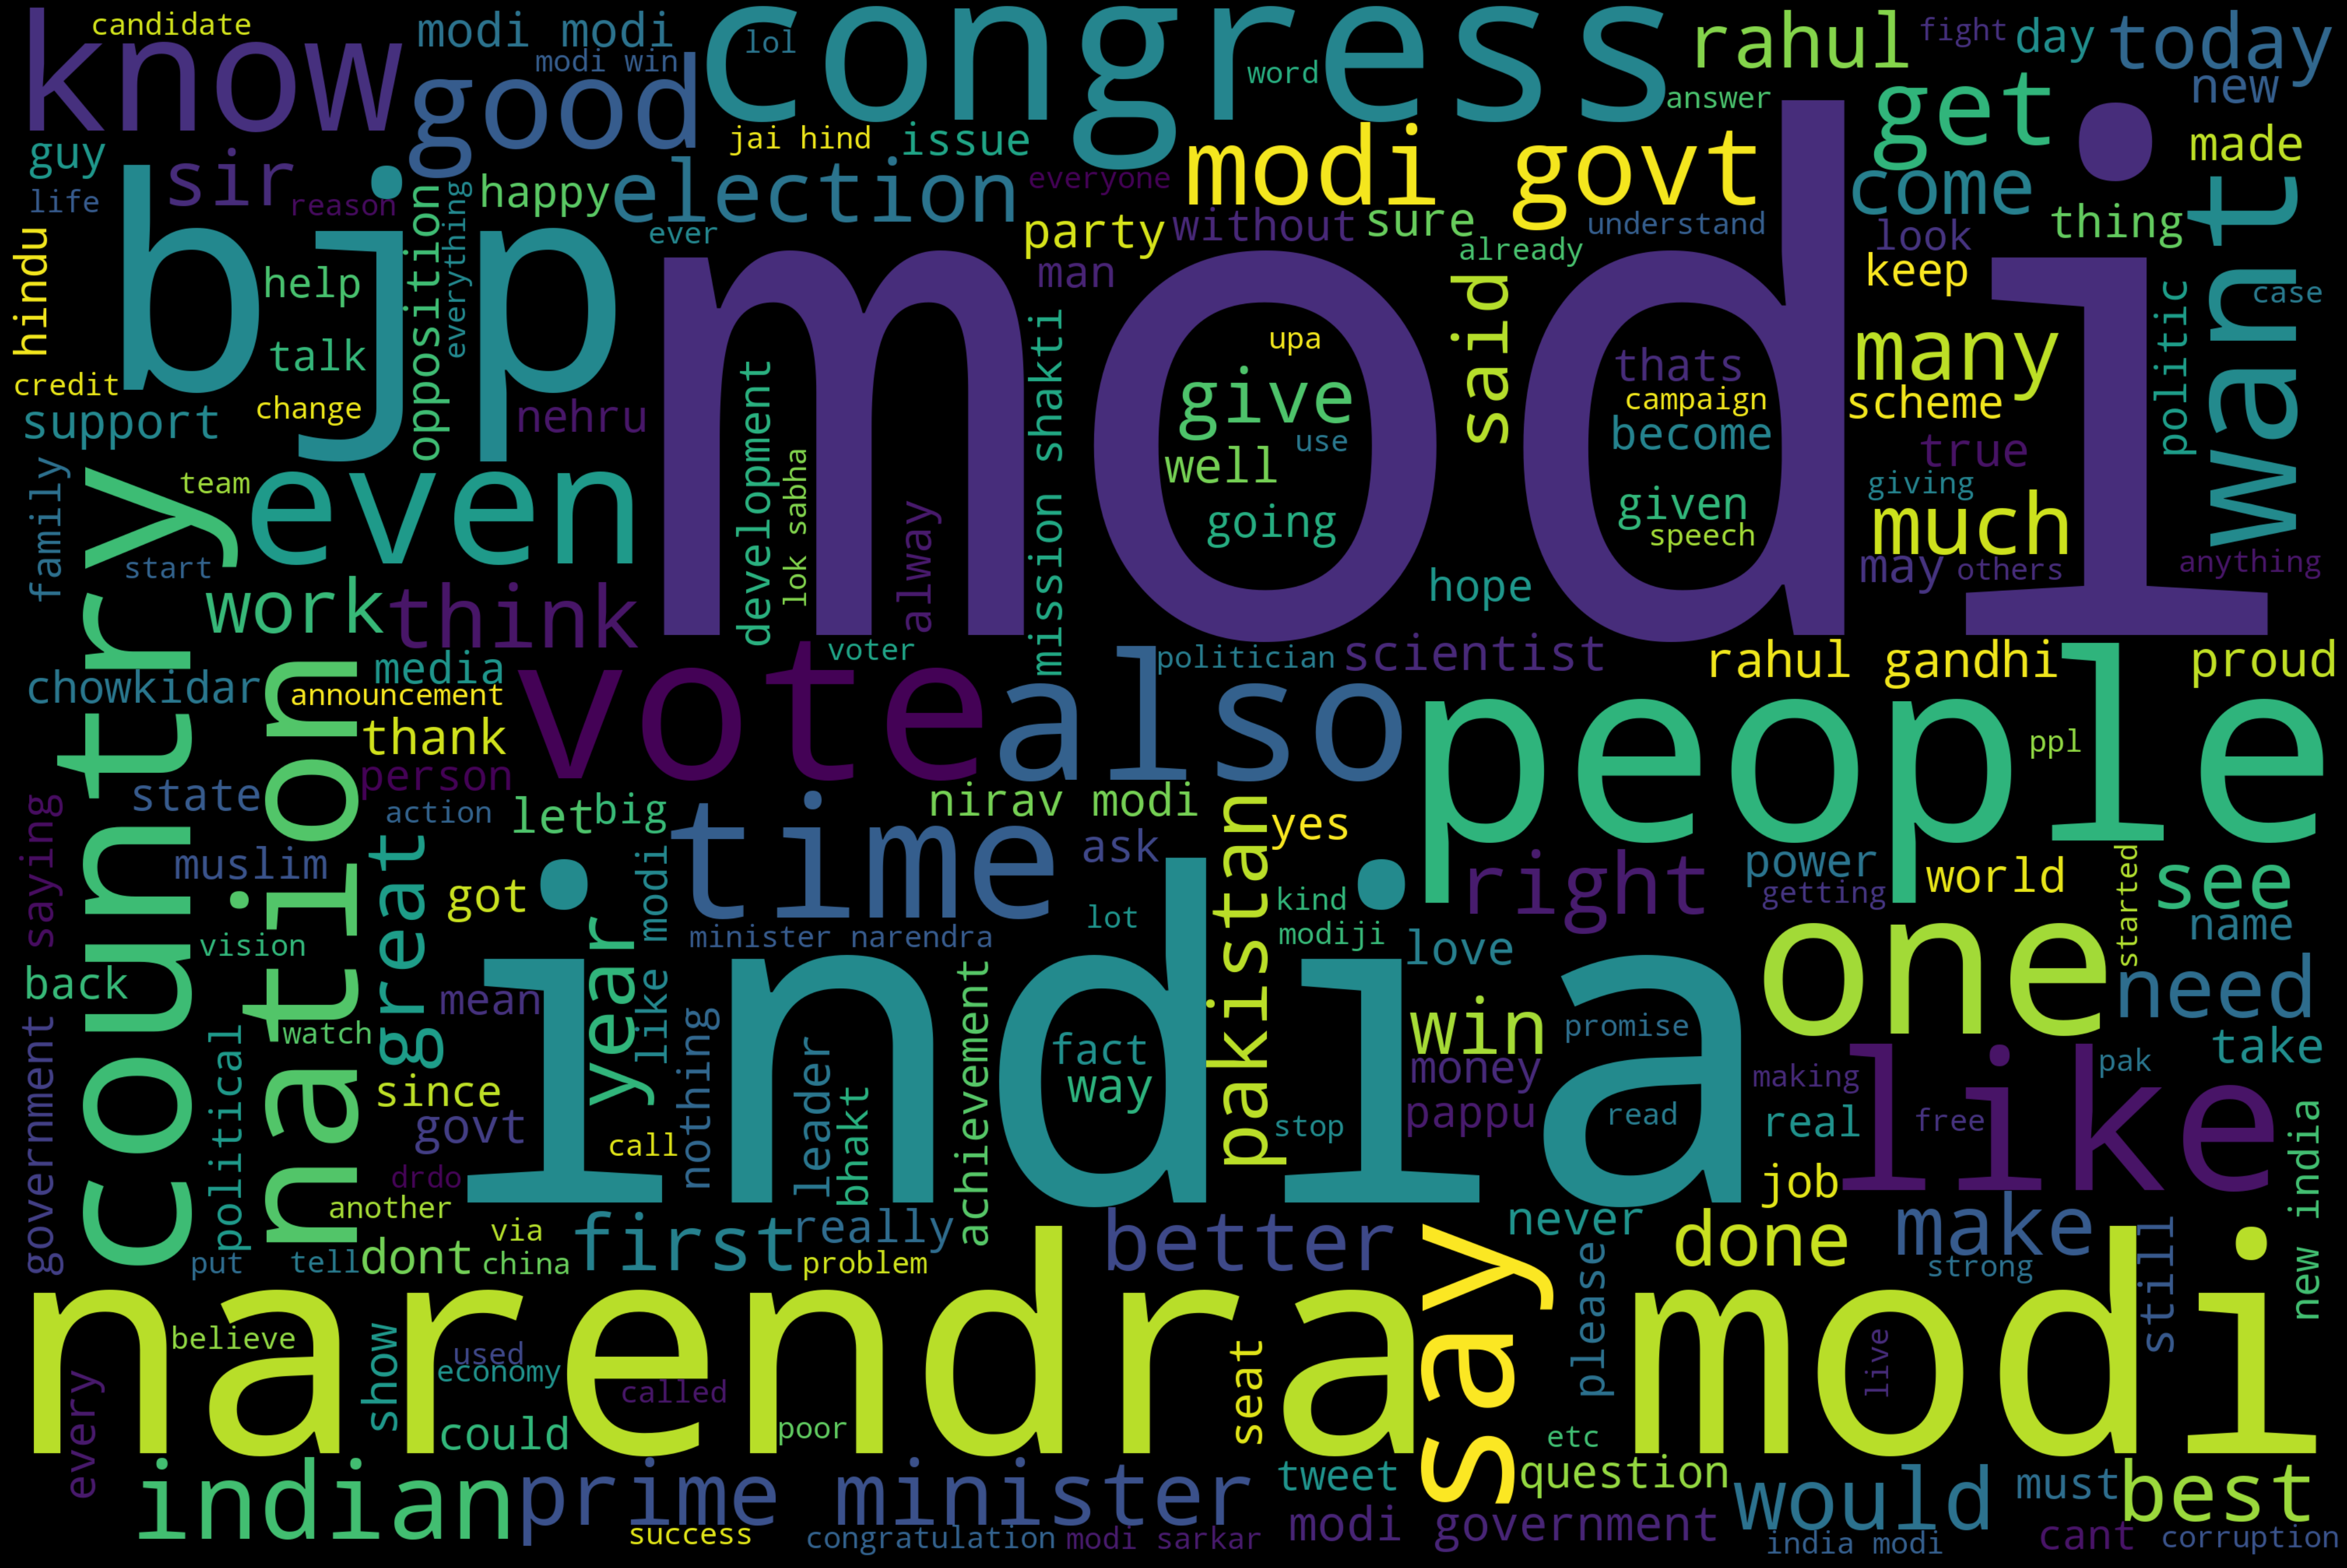

In [20]:
# positive tweets

# Concatenate all positive tweets
positive_tweets = ''
for tweet in df[df['category'] == 1.0]['clean_text']:
    positive_tweets += f" {tweet}"

# Create a WordCloud object
wordcloud = WordCloud(
    width=3000, height=2000, background_color='black',
    stopwords=set(nltk.corpus.stopwords.words("english"))
).generate(positive_tweets)

# Display the word cloud image
fig = plt.figure(figsize=(40, 30), facecolor='k', edgecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# Free up memory
del positive_tweets

## Negative tweets

- Below code is generating a word cloud for the negative tweets from data.
- del keyword is used to delete the text variable to free up memory.

In [ ]:
# negative tweets

# Create a string of all negative tweets
negative_tweets = ' '.join(df[df['category'] == -1.0]['clean_text'])

# Generate wordcloud for negative tweets
wordcloud = WordCloud(
    width=3000, 
    height=2000, 
    background_color='black',
    stopwords=set(nltk.corpus.stopwords.words("english"))
).generate(negative_tweets)

# Plot the wordcloud
fig = plt.figure(figsize=(40, 30), facecolor='k', edgecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# Delete the string of negative tweets to free up memory
del negative_tweets

In [ ]:
# positive tweets

text = ''

for tweet in df[df['category'] == 0.0 ]['clean_text']:
    text += f" {tweet}"
    
wordcloud = WordCloud(
width=3000, height=2000, background_color='black',
stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)

fig = plt.figure(figsize=(40,30), facecolor='k',edgecolor='k')

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show

del text

In [ ]:
##count vectorizer
vec = CountVectorizer(max_features=10000)
vec.fit(df['clean_text'])

trn, val = train_test_split(df, test_size=0.3, random_state=42)

trn_abs = vec.transform(trn['clean_text'])
val_abs = vec.transform(val['clean_text'])

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
clf = OneVsRestClassifier(LogisticRegression(C = 10, n_jobs=-1))
clf.fit(trn_abs, trn['category'])

val_preds = clf.predict(val_abs)
f1_score(val['category'], val_preds, average='micro')

In [ ]:
print(clf.score(val_abs, val['category']))

In [ ]:
accuracy_score(val['category'], val_preds)

In [ ]:
confusion_matrix(val['category'], val_preds)

In [ ]:
print(classification_report(val['category'], val_preds))

In [ ]:
##tf-idf vectorizer
vec = TfidfVectorizer(max_features=10000)
_ = vec.fit(list(df['clean_text']))

trn_abs = vec.transform(trn['clean_text'])
val_abs = vec.transform(val['clean_text'])

In [ ]:
clf = OneVsRestClassifier(LogisticRegression(C = 10, n_jobs=-1))
_ = clf.fit(trn_abs, trn['category'])

val_preds = clf.predict(val_abs)
f1_score(val['category'], val_preds, average='micro')

In [ ]:
print(clf.score(val_abs, val['category']))

In [ ]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from nltk.stem import PorterStemmer
STOP_WORDS = stopwords.words("english")

In [ ]:
# Combining all the above stundents 
from tqdm import tqdm
def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentance in tqdm(text_data):
        sent = decontracted(sentance)
        if type(sent) == type(''):
            example1 = BeautifulSoup(sent)
            sent = example1.get_text()
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        sent = ' '.join(e for e in sent.split() if e.lower() not in STOP_WORDS)
        sent=re.sub("[\d-]",'',sent)#remove digits
        porter=PorterStemmer()
        sent = ' '.join(porter.stem(e) for e in sent.split())
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

In [ ]:
columns=df.columns.values
new_column_names=[]
for i in columns:
    s=i.split()
    d=[]
    for j in s:
        if j==':' or j=='.' or j=='(S)' or j=='(D)':
            pass
        else:
            d.append(j)
    final='_'.join(d)
    new_column_names.append(final)

In [ ]:
df.columns=new_column_names

In [ ]:
remove_dots=[]
for i in df.columns.values:
  remove_dots.append(i.strip('.'))

In [ ]:
df.columns=remove_dots

In [ ]:
#https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
from wordcloud import WordCloud, STOPWORDS
comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the essay column  
for val in df['clean_text'].values: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
    
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords, min_font_size = 10).generate(comment_words) 
  # plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [ ]:
# tokenize
tok = Tokenizer(num_words = 1000000)
# fit
tok.fit_on_texts(df['clean_text'].str.lower().tolist())

vocab_size = len(tok.word_index) + 1

In [ ]:
X_trn = tok.texts_to_sequences(trn['clean_text'])
X_val = tok.texts_to_sequences(val['clean_text'])